Successfully connected to the database


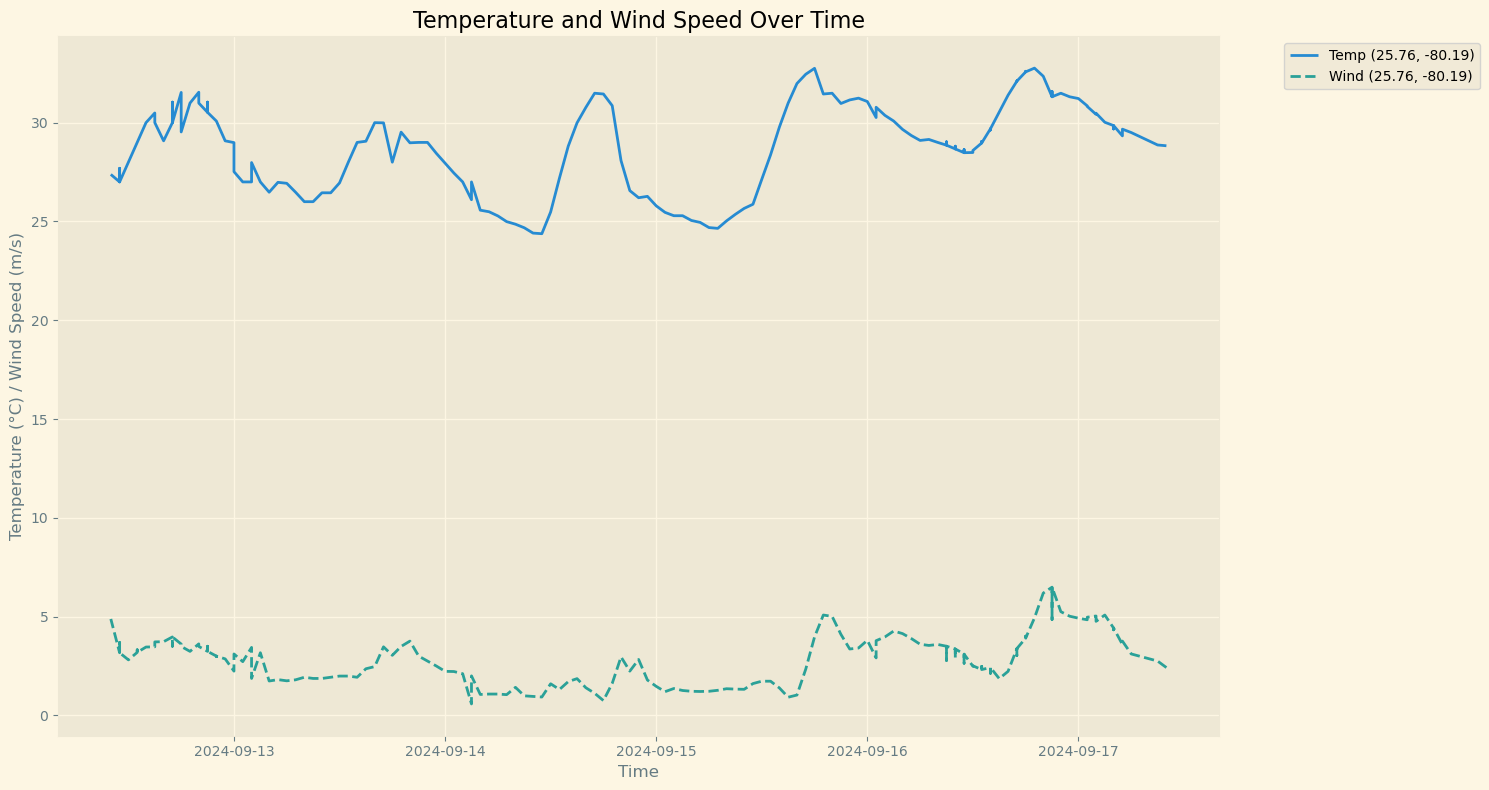

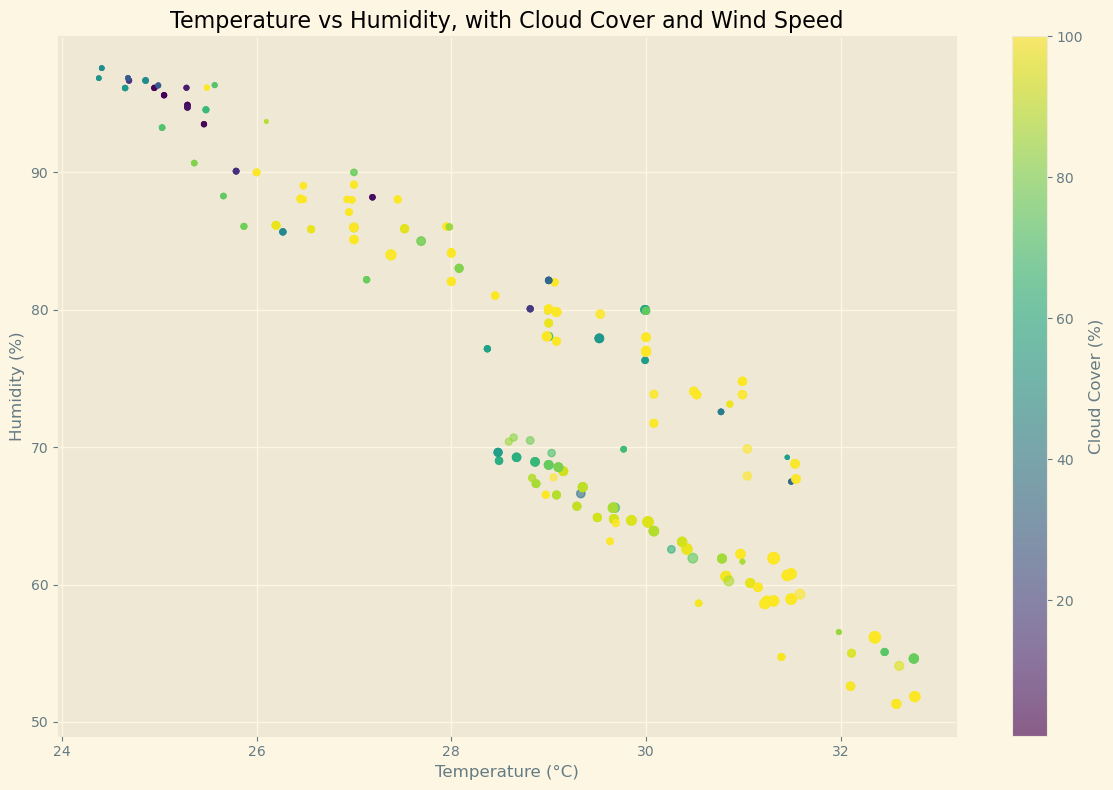

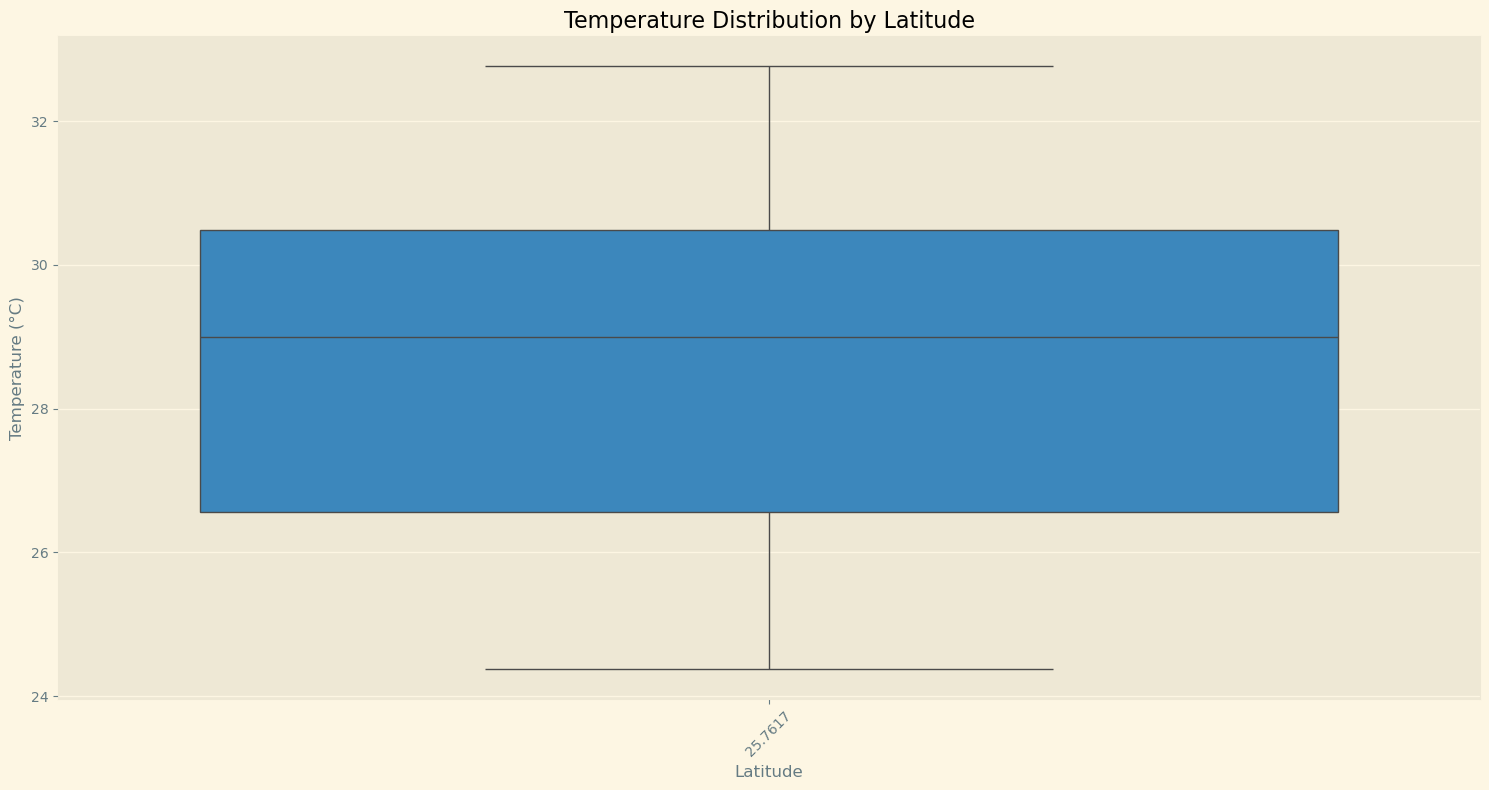

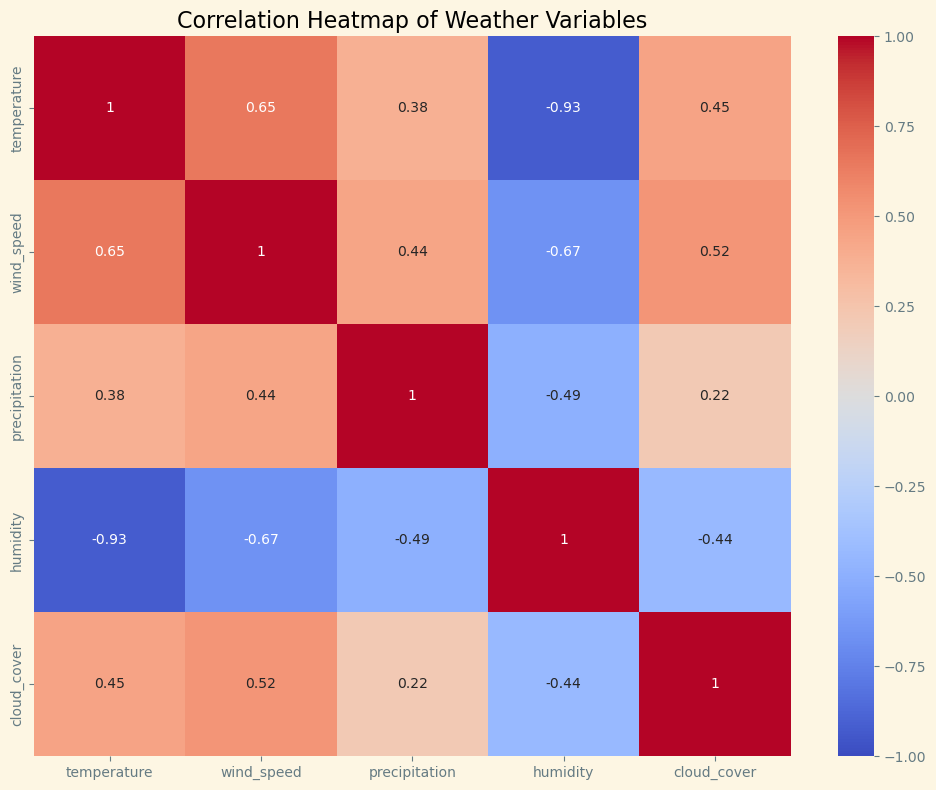

Visualization complete


In [1]:
# notebooks/weather_visualization.ipynb
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text
import time

# Function to attempt database connection with retries
def connect_to_database(max_attempts=5, delay=5):
    DATABASE_URL = os.getenv("DATABASE_URL")
    if not DATABASE_URL:
        raise ValueError("DATABASE_URL environment variable is not set")
    
    for attempt in range(max_attempts):
        try:
            engine = create_engine(DATABASE_URL)
            # Test the connection
            with engine.connect() as conn:
                conn.execute(text("SELECT 1"))
            print("Successfully connected to the database")
            return engine
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {str(e)}")
            if attempt < max_attempts - 1:
                print(f"Retrying in {delay} seconds...")
                time.sleep(delay)
            else:
                raise Exception("Failed to connect to the database after multiple attempts")

# Connect to the database
engine = connect_to_database()

# Load data from the database
query = "SELECT * FROM weather_data ORDER BY timestamp DESC LIMIT 1000"
df = pd.read_sql(query, engine)

# Check if we have data
if df.empty:
    print("No data found in the database. Please ensure you have stored weather data.")
else:
    # Convert timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Set up the plot style
    plt.style.use('Solarize_Light2')

    # 1. Time series plot for temperature and wind speed
    plt.figure(figsize=(15, 8))
    for (lat, lon), group in df.groupby(['latitude', 'longitude']):
        plt.plot(group['timestamp'], group['temperature'], label=f'Temp ({lat:.2f}, {lon:.2f})')
        plt.plot(group['timestamp'], group['wind_speed'], label=f'Wind ({lat:.2f}, {lon:.2f})', linestyle='--')

    plt.title('Temperature and Wind Speed Over Time')
    plt.xlabel('Time')
    plt.ylabel('Temperature (°C) / Wind Speed (m/s)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 2. Scatter plot of temperature vs humidity with cloud cover
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(df['temperature'], df['humidity'], c=df['cloud_cover'], 
                          s=df['wind_speed']*10, alpha=0.6, cmap='viridis')
    plt.colorbar(scatter, label='Cloud Cover (%)')
    plt.title('Temperature vs Humidity, with Cloud Cover and Wind Speed')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Humidity (%)')
    plt.tight_layout()
    plt.show()

    # 3. Box plot of temperature distribution by location
    plt.figure(figsize=(15, 8))
    sns.boxplot(x='latitude', y='temperature', data=df)
    plt.title('Temperature Distribution by Latitude')
    plt.xlabel('Latitude')
    plt.ylabel('Temperature (°C)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 4. Heatmap of correlations between weather variables
    corr = df[['temperature', 'wind_speed', 'precipitation', 'humidity', 'cloud_cover']].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title('Correlation Heatmap of Weather Variables')
    plt.tight_layout()
    plt.show()

print("Visualization complete")